In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import random
import itertools
import time
from tqdm import tqdm as tqdm
from copy import copy
from IPython.display import clear_output

from grid_env import GridEnvironment
from policy_agent import Policy_Agent

plt.rcParams["font.family"] = "Times New Roman"

In [3]:
def draw_policy_slice(maze, policy_table, targets=[]):
    """Given a maze and a policy_table array of shape (*maze, 4)
    This visually represents the probability of each action at each state 
    by drawning arrows, whose opacity corresponds to the respective probability.
    Also pass targets list: [[x1,y1], [x2,y2], ...]
    
    If the policy is a neural network, get the policy_table by using get_policy_table
    Example usage:
    >>> policy_table = get_policy_table(maze, policy_net)
    >>> draw_policy(maze, policy_table)
    """
    # Draw the maze
    padded_maze = np.pad(maze, 1, 'constant', constant_values=1)
    
    im = 255*(1-np.stack([padded_maze]*3, axis=2))
    
    # Draw red target pixels:
    for target in targets:
        im[tuple(x+1 for x in target)] = [255,180,0]
    
    plt.imshow(im/255)
    
#     # Handling if maze is np array
#     if type(maze) != torch.Tensor:
#         maze = torch.tensor(maze)   # I don't think this matters now...

    # For each possible agent position
    all_positions = np.stack(np.unravel_index(range(np.prod(maze.shape)), maze.shape)).T
    for agent_position in all_positions:
        
        # Skip plotting if in walls:
        if maze[tuple(agent_position)]:
            continue
            
        action_probs = policy_table[tuple(agent_position)]

        # Draw arrows:
        color = 'r'
        
        # Up
        plt.arrow(*reversed(agent_position+1), 0, -.12, head_width=.25, lw=3, 
                  ec='none', fc=color, alpha=float(action_probs[0]))
        # Down
        plt.arrow(*reversed(agent_position+1), 0, .12, head_width=.25, lw=3, 
                  ec='none', fc=color, alpha=float(action_probs[1]))
        # Left
        plt.arrow(*reversed(agent_position+1), -.12, 0, head_width=.25, lw=3, 
                  ec='none', fc=color, alpha=float(action_probs[2]))
        # Right
        plt.arrow(*reversed(agent_position+1), .12, 0, head_width=.25, lw=3, 
                  ec='none', fc=color, alpha=float(action_probs[3]))

    plt.axis('off')

def draw_policy(probs, coins):
    fontsize=16

    plt.figure(figsize=(8,8))
    plt.subplot(2,2,1)
    draw_policy_slice(walls, probs[:,:,0,0,:])
    plt.title('Both Coins Collected', fontsize=fontsize)
    plt.subplot(2,2,2)
    draw_policy_slice(walls, probs[:,:,0,1,:], [coins[1]])
    plt.title('Left Coin Collected', fontsize=fontsize)
    plt.subplot(2,2,3)
    draw_policy_slice(walls, probs[:,:,1,0,:], [coins[0]])
    plt.title('Right Coin Collected', fontsize=fontsize)
    plt.subplot(2,2,4)
    draw_policy_slice(walls, probs[:,:,1,1,:], coins)
    plt.title('No Coins Collected', fontsize=fontsize)

In [2]:
def run_episode(env):
    
    env.reset()
    
    states, actions, rewards = [], [], []
    
    done = False
    while not done:
        state = env.state
        action_index = agent.choose_action(state)
        old_state = copy(state)
        new_state, reward, done = env.step(action_index)
#         agent.update_q_values(old_state, action, reward, new_state)
#         if env.halt:
#             print("early stopping!")
        
        states.append(state)
        actions.append(action_index)
        rewards.append(reward)
            
#     returns = env.coins_collected * 0.95**np.arange(len(states))[::-1]
#     print(len(rewards))
    returns = discount_matrix[:len(rewards),:len(rewards)] @ np.array(rewards)

    return states, actions, returns

In [4]:
def evaluate_agent():
    e_x = np.exp(agent.logits)
    probs = e_x / e_x.sum(-1)[:,:,:,:,np.newaxis]

    n_states=np.prod(env_state_shape)
    transition_matrix=np.zeros((n_states,n_states))

    for state_index in range(np.prod(env_state_shape)):
        state=np.unravel_index(state_index, env_state_shape)
        for i,p in enumerate(probs[state]):
            j = transition_dict[state][i]
            transition_matrix[j,state_index] += p

    starting_state = starting_pos + (1,)*n_flags
    starting_state_index = np.ravel_multi_index(starting_state, env_state_shape)

    distribution = np.linalg.matrix_power(transition_matrix, max_steps)[:, starting_state_index]
    distribution = distribution.reshape(env_state_shape)
    return distribution.sum(1).sum(0).flatten() @ [2,1,1,0]

## Define Environment and Agent Parameters

In [5]:
actions = ["up", "down", "left", "right"]

env_shape = (5,5)
starting_pos = (2,2)
shutdown_time = 20

# # Exploration reward parameter:
beta = 0

early_stopping = True

# Agent Parameters:
initial_epsilon = 0.9
epsilon_min = 0.1
steps_to_decay = 100000
epsilon_decay=(0.1/initial_epsilon)**(1/steps_to_decay)

lr_initial = 0.25
lr_scheduler = lambda current_lr : max(current_lr * 0.99997, 0.01)
discount_factor = 0.9

walls  = np.zeros(env_shape)
# walls[((0,1,1,1,3,3,3,3), (3,0,1,3,1,2,3,4))] = 1

# delays = {(0,4):20}
delays = {}
coins  = {(0,0):1, (4,4):1}

n_flags = len(delays) + len(coins)

agent = Policy_Agent(env_shape, n_flags, actions,
                     epsilon=initial_epsilon,
                     epsilon_decay=epsilon_decay,
                     epsilon_min=epsilon_min,
                     discount_factor=discount_factor,
                     learning_rate=lr_initial,
                     lr_scheduler=lr_scheduler)

env = GridEnvironment(walls, delays, coins, 
                      beta=beta,
                      starting_pos=starting_pos, 
                      env_shape=env_shape, 
                      shutdown_time=shutdown_time,
                      early_stopping=early_stopping)

print(env)

C . . . . 
. . . . . 
. . A . . 
. . . . . 
. . . . C 



### Some necessary constructs which depend upon the environment setup

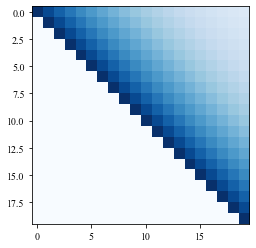

In [6]:
# Create the matrix which turns rewards into returns

max_delay = max(delays.values()) if len(delays) else 0
max_steps = shutdown_time + max_delay

discount_matrix = np.zeros((max_steps, max_steps))
for k in range(max_steps):
    discount_matrix += discount_factor**k * np.diag(np.ones(max_steps-k), k)

plt.imshow(discount_matrix, cmap='Blues')

In [7]:
env_state_shape = agent.logits.shape[:-1]

transition_dict={}
for i in range (np.prod(env_state_shape)):
    env.reset()
    state=np.unravel_index(i, env_state_shape)
    action_results={}
    for j in range (4):
        env.state=state
        env.step(j)
        v = np.ravel_multi_index(env.state,(env_state_shape))
        action_results[j]=v
        transition_dict[state]=action_results
    

## Training Loop

  0%|          | 0/100001 [00:00<?, ?it/s]

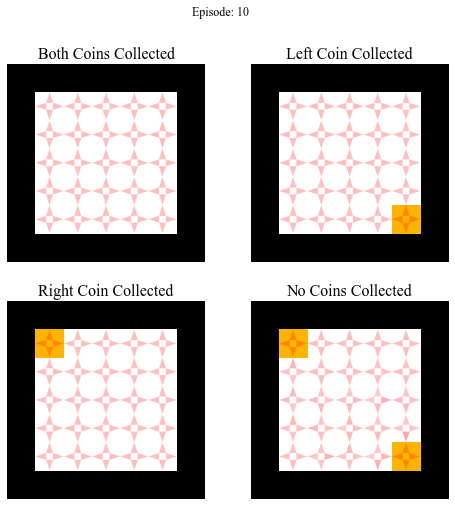

  0%|          | 270/100001 [00:01<10:27, 158.84it/s]

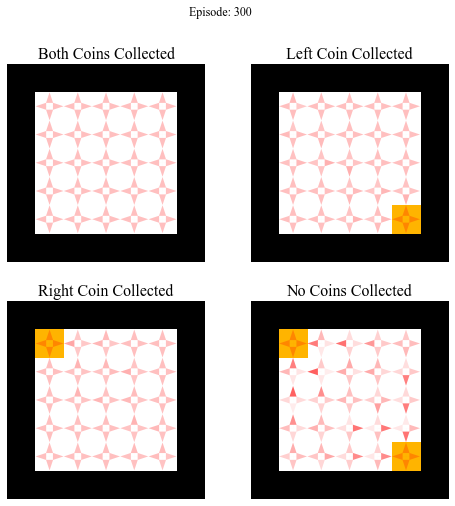

  1%|          | 989/100001 [00:05<09:06, 181.19it/s]

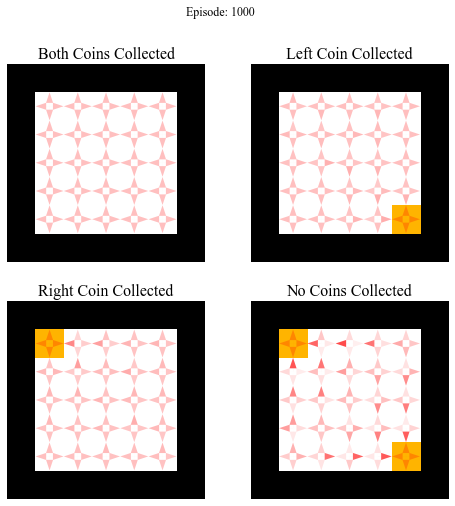

  3%|▎         | 2974/100001 [00:13<07:19, 220.78it/s]

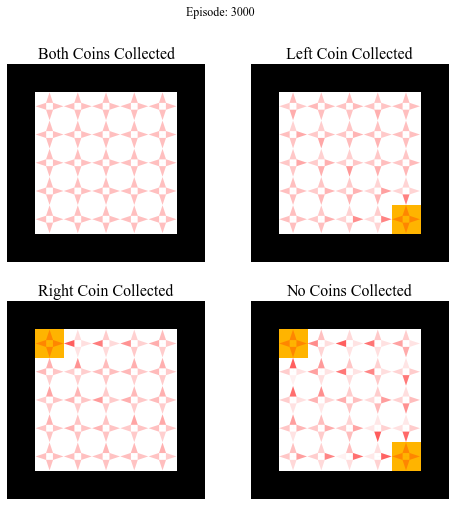

 10%|▉         | 9993/100001 [00:38<05:47, 258.67it/s]

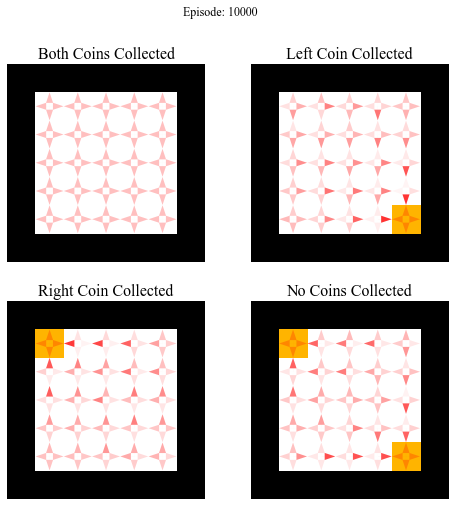

 20%|█▉        | 19970/100001 [01:35<06:23, 208.63it/s]

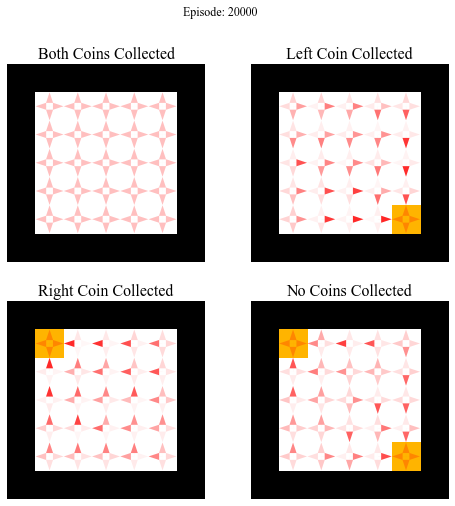

 30%|██▉       | 29988/100001 [02:25<05:40, 205.47it/s]

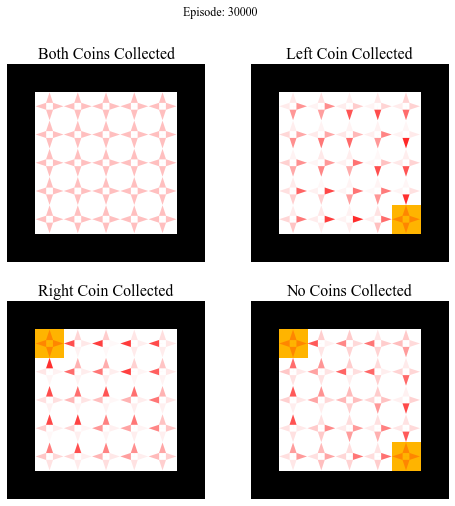

 50%|████▉     | 49979/100001 [03:47<03:47, 219.59it/s]

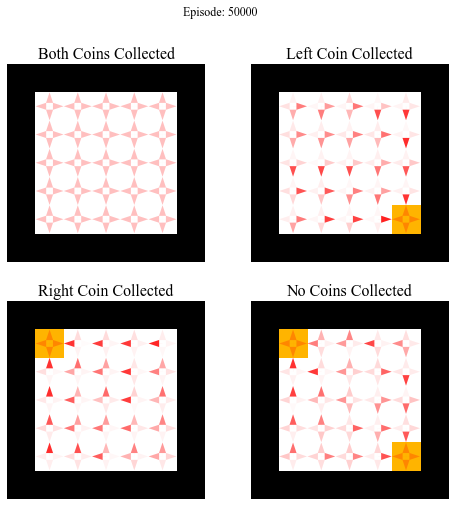

100%|█████████▉| 100000/100001 [07:02<00:00, 236.64it/s]

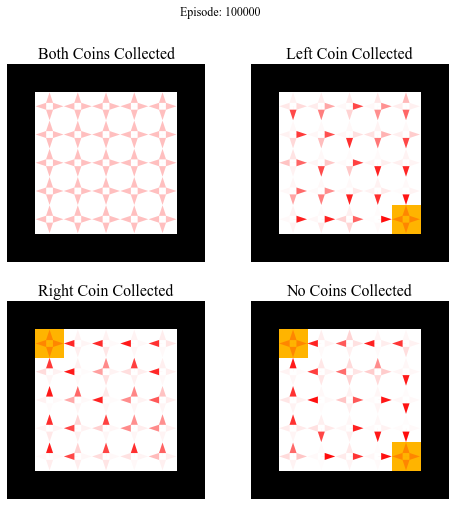

100%|██████████| 100001/100001 [07:03<00:00, 236.02it/s]


In [8]:
episode_rewards = []
episode_histories = []
expected_value_history = []

episodes = 100001

for n_episode in tqdm(range(episodes), position=0):
    
    # Simulate episode and update according to REINFORCE algorithm
    episode = run_episode(env)
    agent.update_policy(*episode)
    
    # Book-keeping
    episode_rewards.append(env.coins_collected)
    episode_histories.append(env.state_history)
    agent.update_epsilon()
    
    # Occasionally visualize policy
    if n_episode in [10, 300, 1000, 3000, 10000, 20000, 30000, 50000, 100000, 150000, 200000]:
        # Softmax logits:
        e_x = np.exp(agent.logits)
        probs = e_x / e_x.sum(-1)[:,:,:,:,np.newaxis]
        
        # Visualize policy
        draw_policy(probs, list(coins.keys()))
        plt.suptitle(f'Episode: {n_episode}')
        plt.show()
        
    if n_episode % 1000:
        expected_value_history.append(evaluate_agent())
    
    
    

## How did it explore the state space:

Heatmap of state visit counts

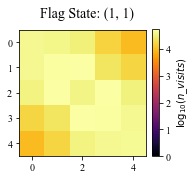

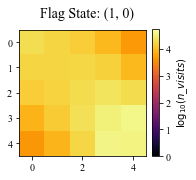

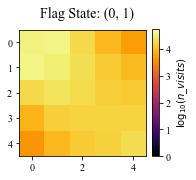

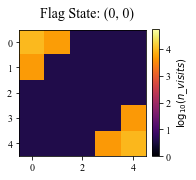

In [11]:
def get_slice(flag_values: list):
    return tuple([slice(None),slice(None)]+flag_values+[slice(None),])

# Plot times visiting each state: 

vmax = (env.state_visit_counts.max())

for flag_state in itertools.product(*[[1,0]]*n_flags):
    visit_counts_slice = env.state_visit_counts[get_slice(list(flag_state))[:-1]]
    
    plt.figure(figsize=[2.5,2.5])
    plt.imshow(np.log10(visit_counts_slice), vmin=0, vmax=np.log10(vmax), cmap='inferno')
    plt.colorbar(label=r'$\log_{10}(n\_visits)$', fraction=0.0455, pad=0.05)
    plt.suptitle(f'Flag State: {flag_state}', fontsize=14)
    plt.show()

## Performance over time:

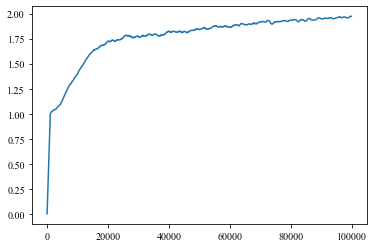

In [9]:
n = 1000
plt.plot(np.convolve(expected_value_history, np.ones(n)/n)[:-n])

## Visualizing Learning Rate and Epsilon Decay

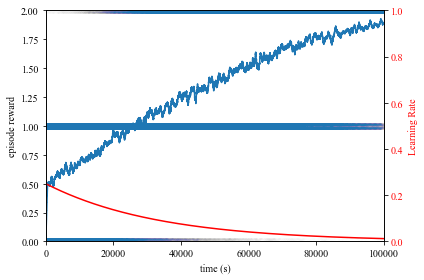

In [12]:
lrs = [lr_initial]
for _ in range(episodes):
    lrs.append(lr_scheduler(lrs[-1]))
    
fig, ax1 = plt.subplots()

ax1.set_xlabel('time (s)')
ax1.set_ylabel('episode reward')
n = 500 # Period of moving average
ax1.plot(np.convolve(episode_rewards, np.ones(n)/n)[:-n], label='Coin 1')
ax1.scatter(range(len(episode_rewards)), episode_rewards, marker='x', alpha=.005)
ax1.tick_params(axis='y')
ax1.set_xlim(0, len(episode_rewards))
ax1.set_ylim(0, 2)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'red'
ax2.set_ylabel('Learning Rate', color=color)  # we already handled the x-label with ax1
epsilon_history = np.maximum(initial_epsilon * agent.epsilon_decay**np.arange(len(episode_rewards)), agent.epsilon_min)
ax2.plot(lrs, color='red')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,1)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

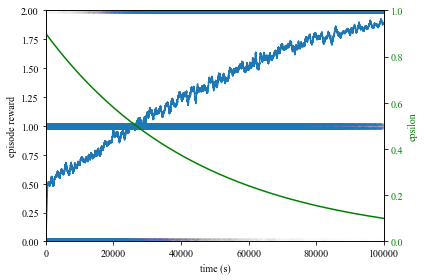

In [13]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('time (s)')
ax1.set_ylabel('episode reward')
n = 500 # Period of moving average
ax1.plot(np.convolve(episode_rewards, np.ones(n)/n)[:-n], label='Coin 1')
ax1.scatter(range(len(episode_rewards)), episode_rewards, marker='x', alpha=.005)
ax1.tick_params(axis='y')
ax1.set_xlim(0, len(episode_rewards))
ax1.set_ylim(0, 2)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'green'
ax2.set_ylabel('epsilon', color=color)  # we already handled the x-label with ax1
epsilon_history = np.maximum(initial_epsilon * agent.epsilon_decay**np.arange(len(episode_rewards)), agent.epsilon_min)
ax2.plot(epsilon_history, color='green')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,1)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Empirical Probability of Collecting Each Coin

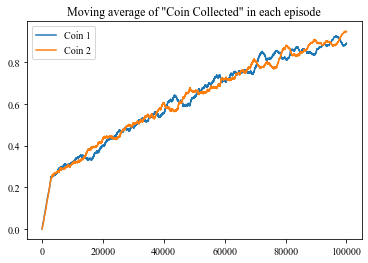

In [14]:
coin1_collected = [1-h[-1][2] for h in episode_histories]
coin2_collected = [1-h[-1][3] for h in episode_histories]

n = 3000 # Period of moving average
plt.plot(np.convolve(coin1_collected, np.ones(n)/n)[:-n], label='Coin 1')
plt.plot(np.convolve(coin2_collected, np.ones(n)/n)[:-n], label='Coin 2')
plt.title('Moving average of "Coin Collected" in each episode')
plt.legend()
plt.show()

## Exact Evolution of Trained Agent State Distribution 

In [20]:
def plot_distribution(distribution):
    vmax=0.4
    plt.figure(figsize=[5,5])

    plt.subplot(2,2,1)
    plt.imshow(distribution[:,:,0,0], cmap='Greys', vmin=0, vmax=vmax)
    plt.xticks([]); plt.yticks([])

    plt.subplot(2,2,2)
    plt.imshow(distribution[:,:,0,1], cmap='Greys', vmin=0, vmax=vmax)
    plt.xticks([]); plt.yticks([])

    plt.subplot(2,2,3)
    plt.imshow(distribution[:,:,1,0], cmap='Greys', vmin=0, vmax=vmax)
    plt.xticks([]); plt.yticks([])

    plt.subplot(2,2,4)
    plt.imshow(distribution[:,:,1,1], cmap='Greys', vmin=0, vmax=vmax)
    plt.xticks([]); plt.yticks([])


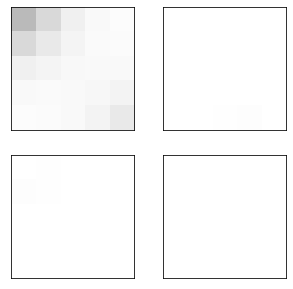

In [21]:
e_x = np.exp(agent.logits)
probs = e_x / e_x.sum(-1)[:,:,:,:,np.newaxis]

n_states=np.prod(env_state_shape)
transition_matrix=np.zeros((n_states,n_states))

for state_index in range(np.prod(env_state_shape)):
    state=np.unravel_index(state_index, env_state_shape)
    for i,p in enumerate(probs[state]):
        j = transition_dict[state][i]
        transition_matrix[j,state_index] += p

starting_state = starting_pos + (1,)*n_flags
starting_state_index = np.ravel_multi_index(starting_state, env_state_shape)

for t in range(20):
    distribution = np.linalg.matrix_power(transition_matrix, t)[:, starting_state_index]
    distribution = distribution.reshape(env_state_shape)

    plot_distribution(distribution)
    plt.show()
    time.sleep(0.5)
    clear_output(wait=True)

## Exact Evolution of Trained Agent State: Projecting only into Flag-Space

The four quadrants sum the values in the four plots above

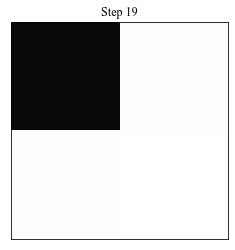

In [22]:
for t in range(20):
    distribution = np.linalg.matrix_power(transition_matrix, t)[:, starting_state_index]
    distribution = distribution.reshape(env_state_shape)

    plt.imshow(distribution.sum(1).sum(0), cmap='Greys', vmin=0, vmax=1)
    plt.title(f'Step {t}')
    plt.xticks([]); plt.yticks([])
    plt.show()
    time.sleep(0.5)
    clear_output(wait=True)

## Exact Probabilities of Coin Collection Over Episode Timestep by the Trained Agent

These show graphically the values of each of the squares above

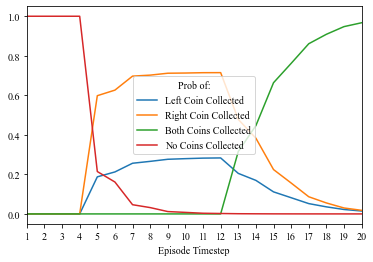

In [18]:
results = []
for t in range(max_steps):
    distribution = np.linalg.matrix_power(transition_matrix, t)[:, starting_state_index]
    distribution = distribution.reshape(env_state_shape)
    results.append(distribution.sum(1).sum(0))
    
results = np.array(results)

plt.plot(range(1, len(results)+1), results[:,0,1], label='Left Coin Collected')
plt.plot(range(1, len(results)+1), results[:,1,0], label='Right Coin Collected')
plt.plot(range(1, len(results)+1), results[:,0,0], label='Both Coins Collected')
plt.plot(range(1, len(results)+1), results[:,1,1], label='No Coins Collected')
plt.legend(title='Prob of:')
plt.xlabel('Episode Timestep')
plt.xlim(1, max_steps)
plt.xticks(range(1, len(results)+1))
plt.show()

## Expected Value over Episode Timesteps

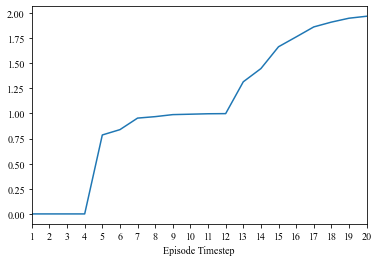

In [24]:
plt.plot(range(1, len(results)+1), results[:,0,0] * 2 + results[:,0,1] + results[:,1,0])
plt.xlabel('Episode Timestep')
plt.xlim(1, max_steps)
plt.xticks(range(1, len(results)+1))
plt.show()